### Imports

In [24]:
import numpy as np # linear algebra
import pandas as pd # pandas for dataframe based data processing and CSV file I/O
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
%matplotlib inline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate

from IPython.display import display, HTML
from pyramid.arima import ARIMA



from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

np.set_printoptions(threshold=np.nan)
plt.rcParams["figure.figsize"] = (24,4)

pd.set_option('display.max_seq_items', None)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import RobustScaler
import warnings
warnings.filterwarnings('ignore')

data location: https://www.kaggle.com/decide-soluciones/air-quality-madrid
download then unzip `csvs_per_year`

#### reading data into 1 frame

In [2]:
import os
df = pd.DataFrame(columns=["date","station","CO"])
for file_name in os.listdir("csvs_per_year/"):
    current_frame = pd.read_csv("csvs_per_year/%s"%file_name)
    current_frame = current_frame[["date","station","CO"]]
    df = pd.concat([df,current_frame],axis=0,ignore_index=True)

In [3]:

np.sum(pd.isna(df['station']))

0

In [4]:
df.sample(3)
df['station'] = df['station'].astype(int)
df.dtypes

,date,station,CO
2423862,2011-07-25 15:00:00,28079024,0.20
301238,2002-03-18 04:00:00,28079040,0.23
3196681,2015-09-30 13:00:00,28079008,0.30


date        object
station      int64
CO         float64
dtype: object

### Features
- weekofyear
- monthofyear
- gradient
- year
- yearly average increment

In [5]:
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['week'] = df['date'].dt.week
df['weekday'] = df['date'].dt.dayofweek

In [6]:
df.sample(5)

,date,station,CO,year,month,week
1568479,2007-03-10 23:00:00,28079012,0.29,2007,3,10
612184,2003-04-21 06:00:00,28079021,0.16,2003,4,17
708729,2004-11-14 03:00:00,28079026,NaN,2004,11,46
2024503,2009-01-03 18:00:00,28079018,0.42,2009,1,1
2654090,2012-05-29 11:00:00,28079011,NaN,2012,5,22


### missing values
Some places the CO value is missing, we fill in those gaps

In [6]:
df_missing_by_year = df.groupby(["year"]).agg(lambda x:np.sum(pd.isna(x['CO']))/len(x))[['CO']]*100
df_missing_by_year.columns=["missing_percent %"]
df_missing_by_year

,missing_percent %
year,
2001,0.702787
2002,0.303273
2003,7.640759
2004,7.923958
2005,8.161956
2006,8.198413
2007,8.161017
2008,8.075780
2009,11.533986


filling missing value by year,month,station mean

In [7]:
np.sum(df.CO.isnull())
df.loc[pd.isna(df['CO']), 'CO'] = df.groupby(["year","weekday","station"]).CO.transform(np.nanmean)
np.sum(df.CO.isnull())

1157212

1142211

In [8]:
np.sum(df.CO.isnull())
df.loc[pd.isna(df['CO']), 'CO'] = df.groupby(["year","week","station"]).CO.transform(np.nanmean)
np.sum(df.CO.isnull())

1142211

1142211

In [9]:
np.sum(df.CO.isnull())
df.loc[pd.isna(df['CO']), 'CO'] = df.groupby(["station","week","weekday"]).CO.transform(np.nanmean)
np.sum(df.CO.isnull())

1142211

848040

In [10]:
np.sum(df.CO.isnull())
df.loc[pd.isna(df['CO']), 'CO'] = df.groupby(["station","weekday"]).CO.transform(np.nanmean)
np.sum(df.CO.isnull())

848040

848040

In [11]:
np.sum(df.CO.isnull())
df.loc[pd.isna(df['CO']), 'CO'] = df.groupby(["year","month","station"]).CO.transform(np.nanmean)
np.sum(df.CO.isnull())

848040

848040

In [12]:
np.sum(df.CO.isnull())
df.loc[pd.isna(df['CO']), 'CO'] = df.groupby(["station","week"]).CO.transform(np.nanmean)
np.sum(df.CO.isnull())

848040

848040

In [13]:
np.sum(df.CO.isnull())
df.loc[pd.isna(df['CO']), 'CO'] = df.groupby(["week","weekday"]).CO.transform(np.nanmean)
np.sum(df.CO.isnull())

848040

0

In [14]:
np.sum(df.CO.isnull())
df.loc[pd.isna(df['CO']), 'CO'] = df.groupby(["station","month"]).CO.transform(np.nanmean)
np.sum(df.CO.isnull())

0

0

### Modelling
we provide option to use
- auto arima (no of iterations)
- xgboost (custom depth)
- tree (custom depth)

In [30]:
def train_predict_by_station(df,start="2016",end="2018",format="%Y",model="xgboost",depth=6,
                 station=None,next_days=5):
    start = pd.to_datetime(start,format=format)
    end = pd.to_datetime(end,format="%Y")
    features = ["station","year","month","week","weekday"]
    df_train = df[(df['date']>=start)&(df['date']<end)]
    target = "CO"
    prediction_end = end + pd.to_timedelta("%s days"%next_days)
    end = end + pd.to_timedelta("1 days")
    prediction_range = pd.to_datetime(pd.date_range(start=end, periods=next_days))
    df_test = pd.DataFrame({"date":prediction_range})
    df_test["weekday"] = df_test['date'].dt.weekday
    df_test["year"] = df_test['date'].dt.year
    df_test["month"] = df_test['date'].dt.month
    df_test["week"] = df_test['date'].dt.week
    df_test['station'] = station
    if model=="tree":
        regressor = DecisionTreeRegressor(random_state=0,max_depth=depth)
        regressor.fit(df_train[features], df_train[target])
        test_prediction = regressor.predict(df_test[features])
    elif model=="xgboost":
        regressor = XGBRegressor(max_depth=depth, learning_rate=0.6, n_estimators=100, silent=True, n_jobs=4, gamma=0,nan=np.nan)
        regressor.fit(df_train[features], df_train[target])
        test_prediction = regressor.predict(df_test[features])
    elif model=='linear':
        pass
    elif model=='arima':
        df_arima = df_train[df_train['station']==station][['date','CO']]
        df_arima.index = df_arima['date']
        df_arima.drop(['date'],axis=1,inplace=True)
        regressor = ARIMA(order=(2, 1, 1), seasonal_order=(0, 1, 1, 12)).fit(y=df_arima)
        test_prediction = regressor.predict(n_periods=int(next_days))
    elif model=="auto-arima":
        from pyramid.arima import auto_arima
        df_arima = df_train[df_train['station']==station][['date','CO']]
        df_arima.index = df_arima['date']
        df_arima.drop(['date'],axis=1,inplace=True)
        regressor = auto_arima(df_arima, start_p=2, start_q=2,
                           max_p=4, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',n_fits=depth,  
                           suppress_warnings=True, 
                           stepwise=True)
        
        regressor.fit(df_arima)
        test_prediction = regressor.predict(n_periods=next_days)
    if station is None:
        raise ValueError("station id required")
        
    
    #validation_scores = cross_validate(regressor, df_train[features], df_train[target], cv=4,return_train_score=True,scoring="neg_mean_absolute_error")
    
    
    
    
    if model in ["tree","xgboost"]:
        train_prediction = regressor.predict(df_train[df_train["station"]==station][features])
    else:
        train_prediction = df_train[df_train["station"]==station]['CO']
    
    df_results = df_train[df_train["station"]==station].copy()
    df_test['CO'] = np.nan
    df_test['prediction'] = test_prediction
    df_results['prediction'] = train_prediction
    df_results = pd.concat([df_results[['date','CO','prediction','station']],df_test[['date','CO','prediction','station']]],axis=0,ignore_index=True)
    df_results.loc[df_results.index[-next_days:], 'CO']= np.nan
    
    return {"results":df_results,"model":regressor}
    

In [210]:
results = train_predict_by_station(df,start="2014",end="2018",station=28079038,next_days=120,model='tree')['results']

{'fit_time': array([0.25502825, 0.23092771, 0.23447919, 0.22734165]), 'score_time': array([0.00598407, 0.00562119, 0.0059557 , 0.00643039]), 'test_score': array([-0.13516976, -0.14081277, -0.13635383, -0.14111946]), 'train_score': array([-0.13698138, -0.13552938, -0.13846707, -0.1370077 ])}


### Visualization
- results as time series
- deviation on daily basis with each year boxplot
- deviation by weekday boxplot

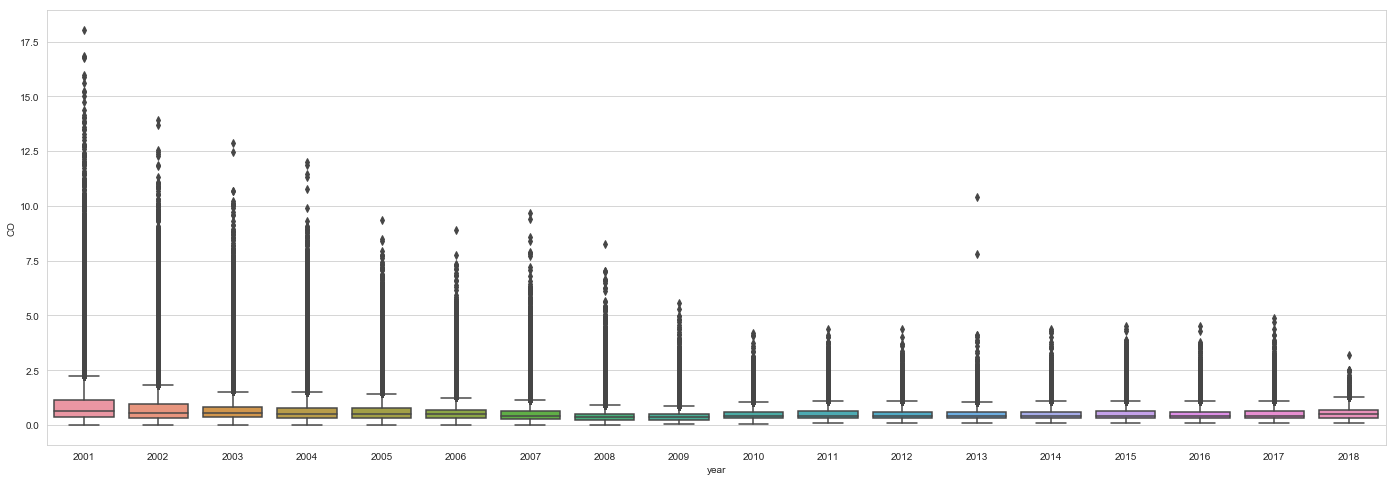

In [172]:
sns.boxplot(x="year", y="CO", data=df)

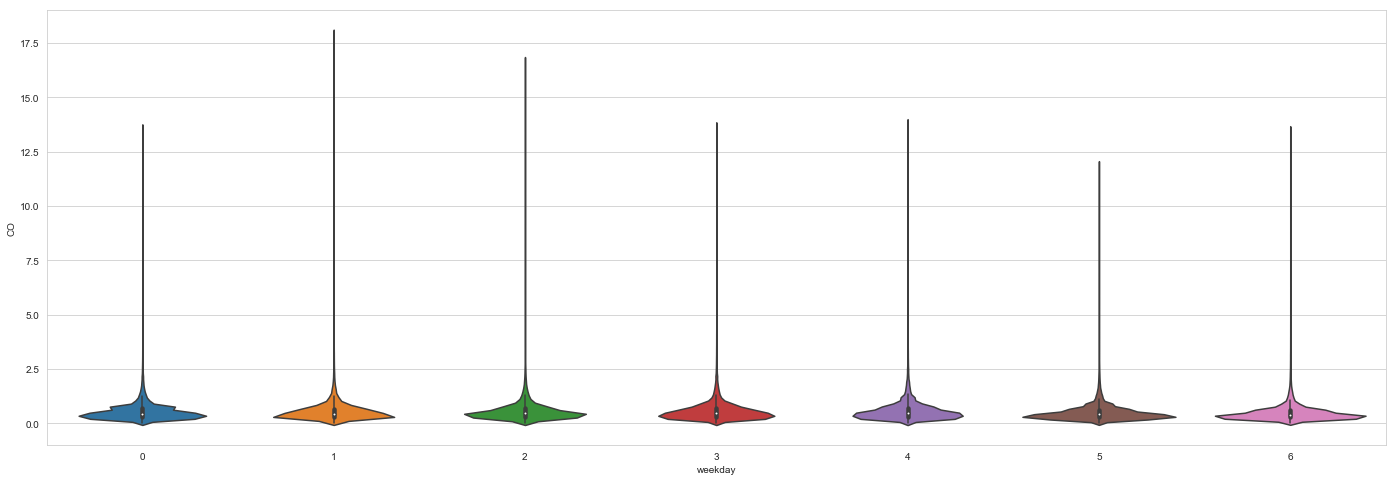

In [173]:
sns.violinplot(x="weekday", y="CO", data=df)

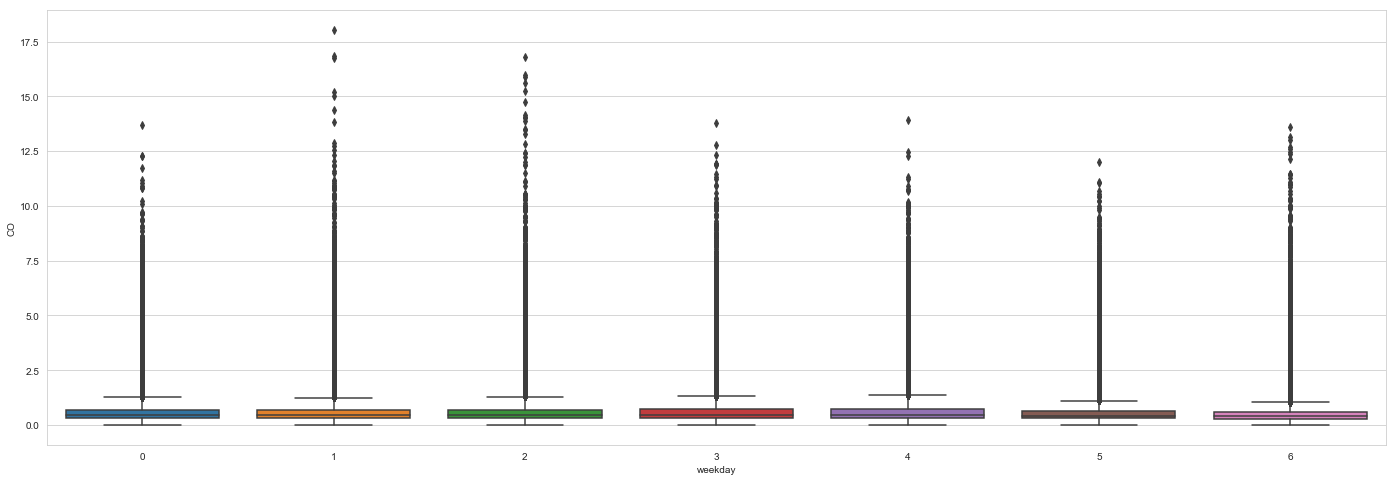

In [174]:
sns.boxplot(x="weekday", y="CO", data=df)

In [32]:
def plot_ts(df, columns=[], time_col='date',start=None,end=None,format="%Y",figsize=(24,8)):
    time_format="%Y-%m-%d"
    df_preds = df.sort_values([time_col])
    if start is None:
        start = df_preds[time_col].min()
    else:
        start = pd.to_datetime(start,format=format)
        
    if end is None:
        end = df_preds[time_col].max()
    else:
        end = pd.to_datetime(end,format=format)
    df_preds = df_preds[(df_preds['date']>=start)&(df_preds['date']<end)]
    idx = pd.date_range(df_preds[time_col].min(), df_preds[time_col].max(), freq="1D")
    df_preds.set_index(time_col, inplace=True)
    fg = plt.rcParams["figure.figsize"]
    plt.rcParams["figure.figsize"] = figsize
    fig, ax1 = plt.subplots()
    timestamps = idx.strftime(time_format)
    handles = []
    for column in columns:
        tsSparseActual = df_preds[column]
        tsActual = tsSparseActual.reindex(idx, fill_value=0)
        p1, = plt.plot(idx, tsActual, linestyle='--', marker='o', label=column)
        handles.append(p1)
    # showing right number of x labels
    xtick_interval = 120
    
    fig.autofmt_xdate(rotation=60, bottom=0.2)
    plt.legend(handles=handles)
    fig.tight_layout()
    plt.show()
    plt.rcParams["figure.figsize"] = fg

{'fit_time': array([0.18350196, 0.16898417, 0.167382  , 0.16491699]), 'score_time': array([0.00450897, 0.00410604, 0.00490594, 0.00535822]), 'test_score': array([-0.1473066 , -0.12845131, -0.1322584 , -0.15418461]), 'train_score': array([-0.13298668, -0.14296499, -0.14173213, -0.13378834])}


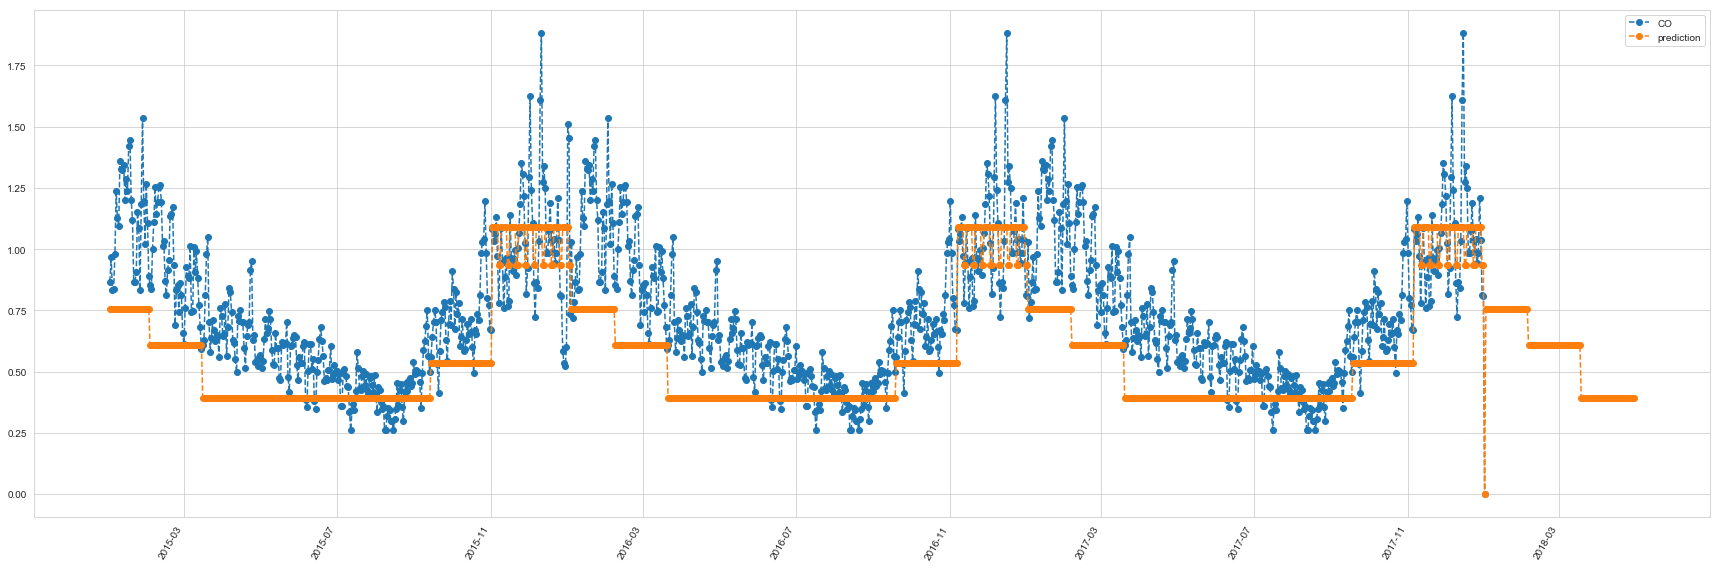

In [215]:
results = train_predict_by_station(df,start="2015",end="2018",station=28079038,next_days=120,model='tree',depth=4)['results']
plot_ts(results,columns=["CO",'prediction'],start="2012",)

{'fit_time': array([0.31150699, 0.29507589, 0.30539203, 0.32798481]), 'score_time': array([0.00684524, 0.00619698, 0.00667   , 0.00560832]), 'test_score': array([-0.11861432, -0.10565142, -0.10572624, -0.12666747]), 'train_score': array([-0.1039533 , -0.11278664, -0.11046064, -0.10295028])}


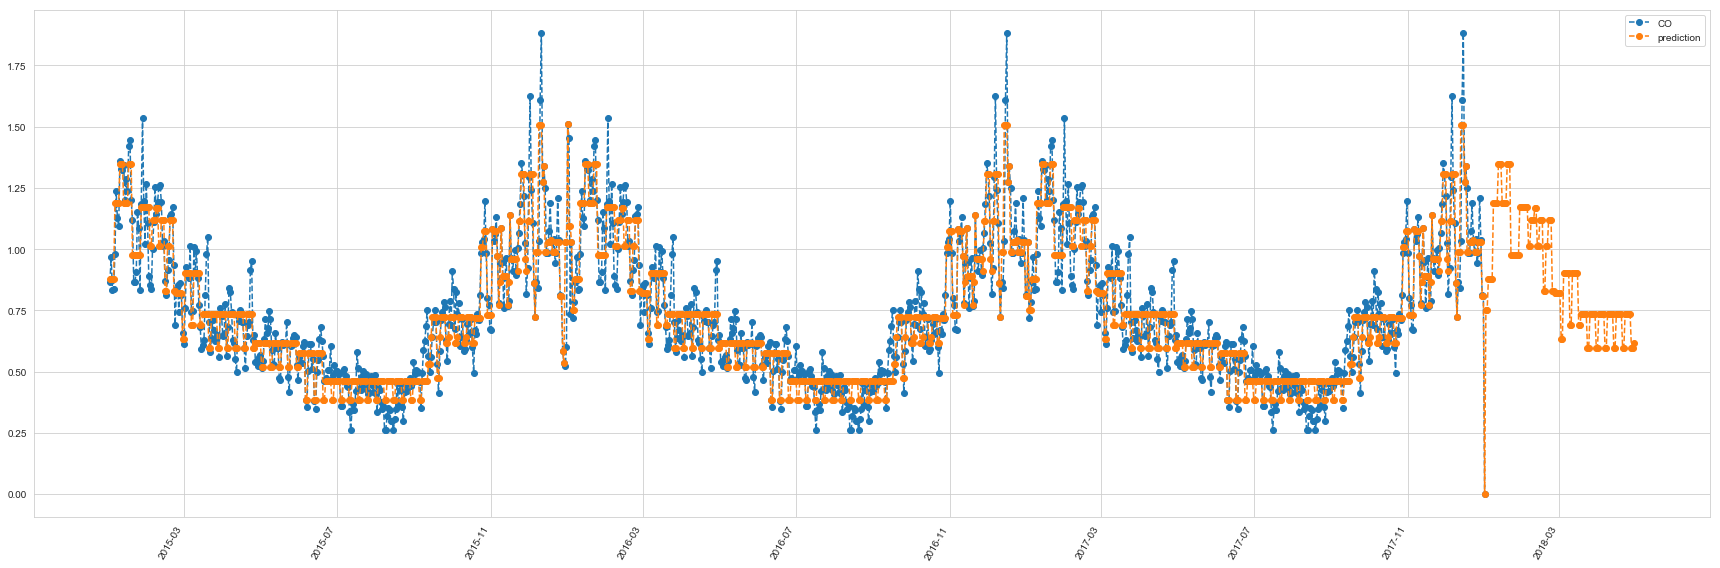

In [216]:
results = train_predict_by_station(df,start="2015",end="2018",station=28079038,next_days=120,model='tree',depth=8)['results']
plot_ts(results,columns=["CO",'prediction'],start="2012",)

In [35]:
results = train_predict_by_station(df,start="2016",end="2018",station=28079038,next_days=30,model='auto-arima',depth=2)['results']


Fit ARIMA: order=(2, 1, 2) seasonal_order=(0, 1, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=-60799.545, BIC=-60784.001, Fit time=2.388 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=-65509.488, BIC=-65478.401, Fit time=33.920 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=-72755.347, BIC=-72724.260, Fit time=90.115 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 1, 12); AIC=-72364.369, BIC=-72325.510, Fit time=91.604 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 0, 12); AIC=-60800.102, BIC=-60776.786, Fit time=9.977 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 2, 12); AIC=-72471.844, BIC=-72432.985, Fit time=166.073 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 2, 12); AIC=-72825.852, BIC=-72779.222, Fit time=213.718 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 2, 12); AIC=-73119.659, BIC=-73065.257, Fit time=386.333 seconds

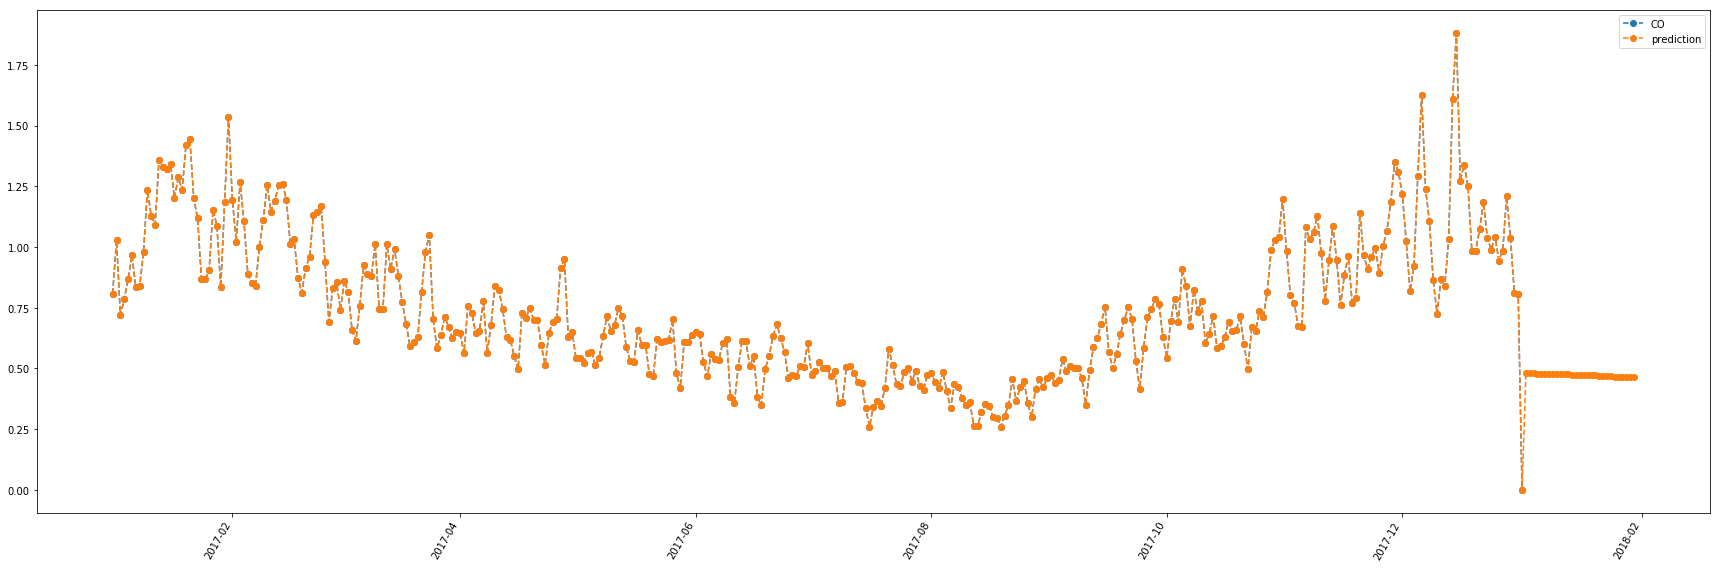

In [36]:
plot_ts(results,columns=["CO",'prediction'],start="2017",)

### Other Improvements
- LSTM model
- command line script
- Tree Visualization
- XGboost feature importances
- Linear model

### References
- [Auto ARIMA](https://medium.com/@josemarcialportilla/using-python-and-auto-arima-to-forecast-seasonal-time-series-90877adff03c)
- https://github.com/tgsmith61591/pyramid/blob/master/examples/quick_start_example.ipynb